In [286]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pydotplus
from sklearn.ensemble import RandomForestClassifier
# from sklearn.externals import 
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import warnings
warnings.simplefilter("ignore")

### Building Dataset

In [12]:
model=DecisionTreeClassifier(min_samples_leaf=10, max_depth=6, min_impurity_decrease=0.001)

In [13]:
features=pd.read_csv('BigCapFeatures.csv')
# targets=pd.concat([pd.read_csv('momentumeEffect.csv'), pd.read_csv("momentumeEffect5.csv")])
targets=pd.read_csv('BigCapMomentum.csv')
targets.drop_duplicates(['ticker'],keep='first',inplace=True)

In [14]:
preYearFeatures=pd.read_csv('BigCapMomentum2017.csv')

In [282]:
preYearFeatures.head(3)

,Unnamed: 0,Symbol,min_1,max_1,var_1,max_1_peroids,buyHold_1,maxDrawBack,preYearMomentum
0,0,A,-0.087603,0.138202,2.927907,"(13, 60)",46.962768,6.217640,0
1,0,ABMD,0.000000,0.237624,3.209953,"(1, 60)",69.296377,6.028203,1
2,0,AAP,-0.070361,0.116333,2.797046,"(11, 50)",-41.532967,5.674570,0


In [16]:
preYearFeatures['preYearMomentum']=preYearFeatures[['min_1','max_1','var_1']].apply(lambda x: 1 if (x[0]+x[1]>=0 and x[1]>=0.15 and x[2]<=12 ) else (-1 if (x[0]<= -0.15 and x[2]<=12) else 0), axis=1)
preYearFeatures.rename({'ticker':'Symbol'}, axis=1, inplace=True)

In [17]:
preYearFeatures.head(3)

,Unnamed: 0,Symbol,min_1,max_1,var_1,max_1_peroids,buyHold_1,maxDrawBack,preYearMomentum
0,0,A,-0.087603,0.138202,2.927907,"(13, 60)",46.962768,6.217640,0
1,0,ABMD,0.000000,0.237624,3.209953,"(1, 60)",69.296377,6.028203,1
2,0,AAP,-0.070361,0.116333,2.797046,"(11, 50)",-41.532967,5.674570,0


In [283]:
features.head(3)

,Unnamed: 0,Symbol,PE,EPSGrowth,RevenueGrowth,logMarketCap,PS,Sector,Sharpe,std,LiquidityRate,CorWithBenchMark
0,0,A,28.447257,0.196970,0.064255,10,4.684263,Healthcare,2.675440,0.164655,0.520762,0.437042
1,0,AA,17.960133,2.409606,0.250483,10,0.945171,Basic Materials,2.329636,0.372822,1.436134,0.346086
2,0,AACG,-7.536467,-0.000000,0.037413,8,0.329082,Consumer Defensive,0.343638,0.502240,0.036839,0.145524


In [284]:
targets.head(3)

,Unnamed: 0,Symbol,min_1,max_1,var_1,max_1_peroids,buyHold_1,maxDrawBack,MomentumEffect
0,0,A,-0.336212,-0.045040,6.318015,"(11, 140)",-1.601901,13.808617,-1
1,0,AAL,-0.286046,0.098800,9.119530,"(5, 50)",-38.677625,11.761279,-1
2,0,AAP,-0.042957,0.420985,11.629514,"(3, 80)",54.658078,8.799882,1


In [20]:
targets['MomentumEffect']=targets[['min_1','max_1','var_1']].apply(lambda x: 1 if (x[0]+x[1]>=0 and x[1]>=0.15 and x[2]<=12 ) else (-1 if (x[0]<= -0.15 and x[2]<=12) else 0), axis=1)

In [21]:
targets['var_1'].quantile([0.25, 0.5, 0.75])

0.25    4.466506
0.50    5.856409
0.75    7.798617
Name: var_1, dtype: float64

In [22]:
targets.rename({'ticker':'Symbol'}, axis=1, inplace=True)

In [23]:
combined=pd.merge(features, targets, how='inner', on=['Symbol'])
combined=pd.merge(combined, preYearFeatures[['Symbol','preYearMomentum']], how='inner', on=['Symbol'])

In [287]:
combined['Year']=2018
combined.head(3)

,Unnamed: 0_x,Symbol,PE,EPSGrowth,RevenueGrowth,logMarketCap,PS,Sector,Sharpe,std,...,preYearMomentum,Year,PE_category,PS_category,std_category,CorWithBenchMark_category,Sharpe_category,RevenueGrowth_category,LiquidityRate_category,preYearMomentum_category
0,0,A,28.447257,0.196970,0.064255,10,4.684263,Healthcare,2.675440,0.164655,...,0,2018,Low,1,-1,1,1,-1,1,1
1,0,AAL,10.679592,-0.140351,0.050448,10,0.793000,Industrials,0.431699,0.286677,...,-1,2018,High,-1,1,1,-1,-1,1,-1
2,0,AAP,18.754647,-0.246499,-0.020266,9,0.719693,Consumer Cyclical,-1.026959,0.404739,...,0,2018,Low,-1,1,-1,-1,-1,1,1


In [25]:
combined.to_csv('Training2018.csv')

In [289]:
combined.loc[:,['preYearMomentum','MomentumEffect']].head(3)

,preYearMomentum,MomentumEffect
0,0,-1
1,-1,-1
2,0,1


#### Seem like momentum effect does not persist

In [27]:
accuracy_score(combined['preYearMomentum'], combined['MomentumEffect'])

0.3556531284302964

In [28]:
combined.drop_duplicates(['Symbol'], keep='first', inplace=True)

In [29]:
combined['PE_category']=combined['PE'].apply(lambda x: 1 if (x>0 and x<15) else (0 if x>0 and x<40 else -1))

In [30]:
combined['PE_category']=combined['PE'].apply(lambda x: 'High' if (x>0 and x<15) else 'Low')

In [31]:
combined.head(3)

,Unnamed: 0_x,Symbol,PE,EPSGrowth,RevenueGrowth,logMarketCap,PS,Sector,Sharpe,std,...,min_1,max_1,var_1,max_1_peroids,buyHold_1,maxDrawBack,MomentumEffect,preYearMomentum,Year,PE_category
0,0,A,28.447257,0.196970,0.064255,10,4.684263,Healthcare,2.675440,0.164655,...,-0.336212,-0.045040,6.318015,"(11, 140)",-1.601901,13.808617,-1,0,2018,Low
1,0,AAL,10.679592,-0.140351,0.050448,10,0.793000,Industrials,0.431699,0.286677,...,-0.286046,0.098800,9.119530,"(5, 50)",-38.677625,11.761279,-1,-1,2018,High
2,0,AAP,18.754647,-0.246499,-0.020266,9,0.719693,Consumer Cyclical,-1.026959,0.404739,...,-0.042957,0.420985,11.629514,"(3, 80)",54.658078,8.799882,1,0,2018,Low


In [32]:
# categorizeColumns=['EPSGrowth', 'PS', 'std', 'CorWithBenchMark', 'logMarketCap','Sharpe']
categorizeColumns=['PS', 'std','CorWithBenchMark','Sharpe', 'RevenueGrowth','LiquidityRate','preYearMomentum']

In [33]:
for col in categorizeColumns:
    quantile=combined[col].quantile(0.5)
    combined[col+'_category']=combined[col].apply(lambda x: 1 if x>= quantile else -1)

In [288]:
combined.replace([np.inf, -np.inf], 0, inplace=True)
combined=combined[combined['PS']<100]
combined.dropna(inplace=True)

In [35]:
# X=combined[categorizeColumns]
X=combined[[cat+'_category' for cat in categorizeColumns] +['PS']]
Y=combined["MomentumEffect"]

In [36]:
# quantile_PS=X['PS'].quantile([0.25, 0.75])
X.head(3)

,PS_category,std_category,CorWithBenchMark_category,Sharpe_category,RevenueGrowth_category,LiquidityRate_category,preYearMomentum_category,PS
0,1,-1,1,1,-1,1,1,4.684263
1,-1,1,1,-1,-1,1,-1,0.793000
2,-1,1,-1,-1,-1,1,1,0.719693


In [37]:
Y.value_counts()

-1    348
 1    287
 0    262
Name: MomentumEffect, dtype: int64

In [38]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 897 entries, 0 to 910
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PS_category                897 non-null    int64  
 1   std_category               897 non-null    int64  
 2   CorWithBenchMark_category  897 non-null    int64  
 3   Sharpe_category            897 non-null    int64  
 4   RevenueGrowth_category     897 non-null    int64  
 5   LiquidityRate_category     897 non-null    int64  
 6   preYearMomentum_category   897 non-null    int64  
 7   PS                         897 non-null    float64
dtypes: float64(1), int64(7)
memory usage: 63.1 KB


In [39]:
pd.DataFrame(Y).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 897 entries, 0 to 910
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   MomentumEffect  897 non-null    int64
dtypes: int64(1)
memory usage: 14.0 KB


In [86]:
Y = np.array(Y)

In [91]:
Y = [Y[i] if Y[i]>=0 else 2 for i in range(len(Y))]

### Train, Valid, Test Split

In [172]:
X_t, X_val, Y_t, Y_val= train_test_split(X,Y, test_size=0.3,stratify=Y)
X_valid, X_test, Y_valid, Y_test = train_test_split(X_val, Y_val, test_size=0.5,stratify=Y_val)

In [173]:
len(X_t), len(X_valid), len(X_test)

(627, 135, 135)

In [174]:
pd.Series(Y_t).value_counts(), pd.Series(Y_valid).value_counts(), pd.Series(Y_test).value_counts()

(2    243
 1    201
 0    183
 dtype: int64,
 2    52
 1    43
 0    40
 dtype: int64,
 2    53
 1    43
 0    39
 dtype: int64)

### Decision Tree and Random Forest

In [175]:
model=DecisionTreeClassifier(min_samples_leaf=20, max_depth=20, min_impurity_decrease=0.001)
model.fit(X_t,Y_t)

DecisionTreeClassifier(max_depth=20, min_impurity_decrease=0.001,
                       min_samples_leaf=20)

In [176]:
prediction=model.predict(X_val)
train_predict=model.predict(X_t)
accuracy_score(train_predict, Y_t), accuracy_score(prediction, Y_val)


(0.5311004784688995, 0.40370370370370373)

In [177]:
dot_data=export_graphviz(model, out_file=None,feature_names= X.columns)
graph=pydotplus.graph_from_dot_data(dot_data)
# graph.write_pdf("dt_tree.pdf")

In [178]:
graph.write_pdf("dt_tree.pdf")

True

In [179]:
forest=RandomForestClassifier(min_samples_leaf=30, max_depth=8, n_jobs=1000, max_features=5)
forest.fit(X_t,Y_t)
pred_forest=forest.predict(X_val)
accuracy_score(pred_forest, Y_val), accuracy_score(forest.predict(X_t), Y_t)

(0.43333333333333335, 0.49122807017543857)

In [180]:
X.columns

Index(['PS_category', 'std_category', 'CorWithBenchMark_category',
       'Sharpe_category', 'RevenueGrowth_category', 'LiquidityRate_category',
       'preYearMomentum_category', 'PS'],
      dtype='object')

### Xgboost

In [278]:
param_grid = {
    'max_depth': [i for i in range(1,9)],
    'learning_rate': [0.05, 0.025, 0.075],
    'gamma': [0, 0.25, 0.5, 1.0, 1.5],
    'reg_lambda': [i for i in range(6)],
}
optimal_params = GridSearchCV(
    estimator=xgb.XGBClassifier(objective="multi:softmax",
                                num_class=3,
                                eval_metric="merror", ## this avoids a warning...
                                seed=35,
                                subsample=0.8,
                                colsample_bytree=1),
    param_grid=param_grid,
    scoring='accuracy',
    verbose=2, 
    n_jobs = 10,
    cv = 5
)
optimal_params.fit(X_t,
                 Y_t,
                verbose=False,
                early_stopping_rounds=30,
                eval_metric='merror',
                eval_set=[(X_valid, Y_valid)])
print(optimal_params.best_params_)


Fitting 5 folds for each of 720 candidates, totalling 3600 fits
{'gamma': 0.25, 'learning_rate': 0.025, 'max_depth': 5, 'reg_lambda': 3}


C:\Users\tao\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [279]:
model_xgb_opt = xgb.XGBRegressor(objective='multi:softmax', 
                                 num_class=3,
                            eval_metric="merror", max_depth = 5,
                                learning_rate=0.025,
                                gamma=0.25,
                                reg_lambda=3)

In [280]:
model_xgb_opt.fit(X_t,
                 Y_t,
                verbose=False,
                early_stopping_rounds=20,
                eval_metric='merror',
                eval_set=[(X_valid, Y_valid)])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eval_metric='merror', gamma=0.25, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.025, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=16,
             num_class=3, num_parallel_tree=1, objective='multi:softmax',
             predictor='auto', random_state=0, reg_alpha=0, reg_lambda=3,
             scale_pos_weight=None, subsample=1, tree_method='exact',
             validate_parameters=1, ...)

In [281]:
accuracy_score(model_xgb_opt.predict(X_test), Y_test)

0.5037037037037037

### Which factor is the most important?

In [295]:
model_xgb_opt.feature_importances_

array([0.054373  , 0.15146916, 0.12125546, 0.07521563, 0.05680757,
       0.38305303, 0.04694186, 0.11088426], dtype=float32)

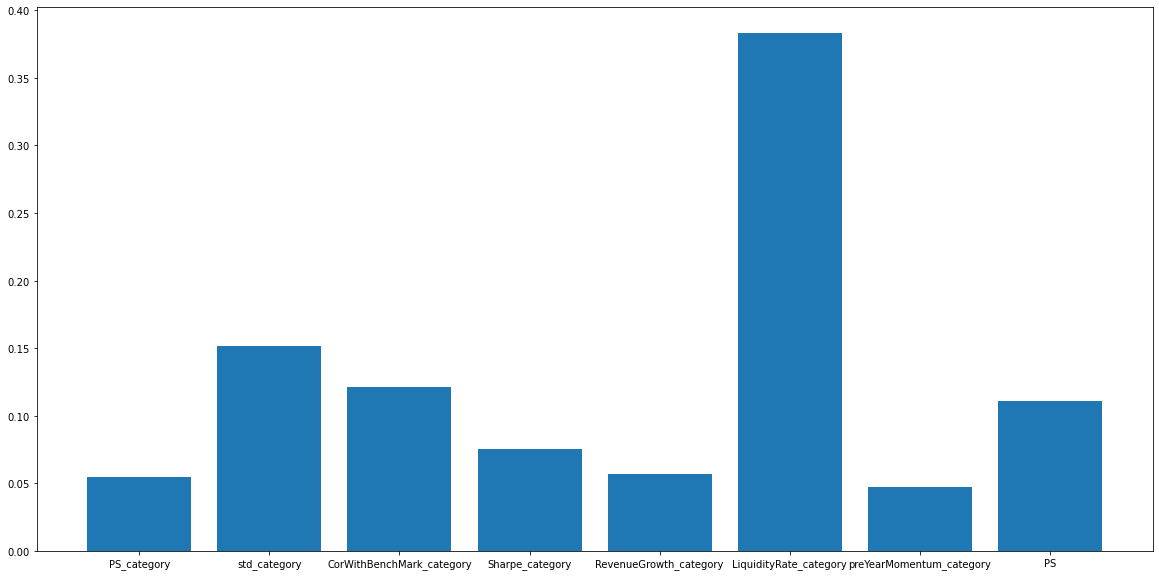

In [304]:
from matplotlib import pyplot as plt

model_xgb_opt.feature_importances_
plt.figure(figsize=(20,10))
plt.bar(range(len(model_xgb_opt.feature_importances_)), (model_xgb_opt.feature_importances_))
_ = plt.xticks(range(len(model_xgb_opt.feature_importances_)), list(X.columns))

In [301]:
features.columns

Index(['Unnamed: 0', 'Symbol', 'PE', 'EPSGrowth', 'RevenueGrowth',
       'logMarketCap', 'PS', 'Sector', 'Sharpe', 'std', 'LiquidityRate',
       'CorWithBenchMark'],
      dtype='object')

### Summary
We improve our test score to 0.50 for 3 categories. We also want to see which factors are the most important.